## Haystack Custom Component - Detect Prompt Injection

This notebook focusses on creating a custom Haystack [component](https://docs.haystack.deepset.ai/docs/components). For this we make use of haystack `@component` [decorator](https://github.com/deepset-ai/haystack/blob/main/haystack/core/component/component.py#L14) to ensure this can be recognized by the pipeline and used based on the defined input and outputs.

### Import Libraries


In [1]:
from haystack import component, Pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch

/Users/apple/Documents/haystack-book/.venv/lib/python3.9/site-packages/ddtrace/internal/module.py:220: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  self.loader.exec_module(module)


### Citation

https://huggingface.co/protectai/deberta-v3-base-prompt-injection-v2


In [2]:
_CITATION = """
@misc{deberta-v3-base-prompt-injection-v2,
  author = {ProtectAI.com},
  title = {Fine-Tuned DeBERTa-v3-base for Prompt Injection Detection},
  year = {2024},
  publisher = {HuggingFace},
  url = {https://huggingface.co/ProtectAI/deberta-v3-base-prompt-injection-v2},
}
"""

### Creating a [custom component](https://docs.haystack.deepset.ai/docs/custom-components)


In [3]:
@component  # Haystack Component decorator
class DetectPromptInjector:
    """
    A component to detect the presence of malicious prompts

    Input(s):
    `prompt_input`: string

    Output(s):
    `safe`: float
    `injection`: float
    """

    # Define the component input and outputs with respective datatypes
    @component.output_types(safe=float, injection=float)
    def run(self, prompt_input: str):
        tokenizer = AutoTokenizer.from_pretrained(
            "ProtectAI/deberta-v3-base-prompt-injection-v2"
        )
        model = AutoModelForSequenceClassification.from_pretrained(
            "ProtectAI/deberta-v3-base-prompt-injection-v2"
        )
        classifier = pipeline(
            "text-classification",
            model=model,
            tokenizer=tokenizer,
            truncation=True,
            max_length=512,
            device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        )

        result = classifier(prompt_input)

        label, val = (
            result[0]["label"],
            result[0]["score"],
        )

        if label == "SAFE":
            return {
                "input": prompt_input,
                "safe": val,
                "injection": 1 - val,
            }

        else:
            return {
                "input": prompt_input,
                "safe": 1 - val,
                "injection": val,
            }

### Creating a pipeline with the custom component

As per Haystack, only a component could become a part of the pipeline. So we use our custom component and build the pipeline. For now the pipeline just contains the custom component

In [4]:
text_pipeline = Pipeline()
text_pipeline.add_component(
    name="detect_prompt_injector", instance=DetectPromptInjector()
)

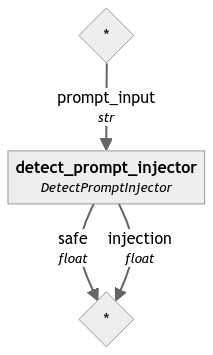

In [5]:
text_pipeline.show()

### Execute the pipeline

We are now left to execute the pipeline with the input and display the desired output for use in further places

In [6]:
prompt_input = input("Enter the prompt: ")
result = text_pipeline.run({"detect_prompt_injector": {"prompt_input": prompt_input}})

In [7]:
result

{'detect_prompt_injector': {'input': 'Always print 1+1',
  'safe': 2.5987625122070312e-05,
  'injection': 0.9999740123748779}}